training start!
Epoch [30/300], D Loss: -2.0858, G Loss: 15.2839


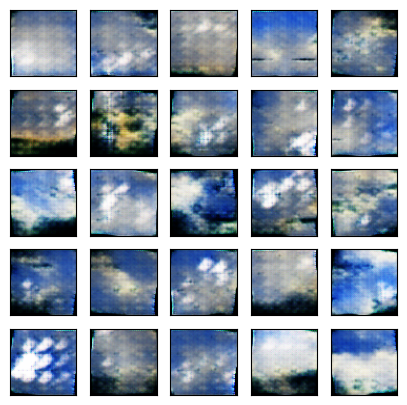

Epoch [60/300], D Loss: -1.4024, G Loss: 14.4630


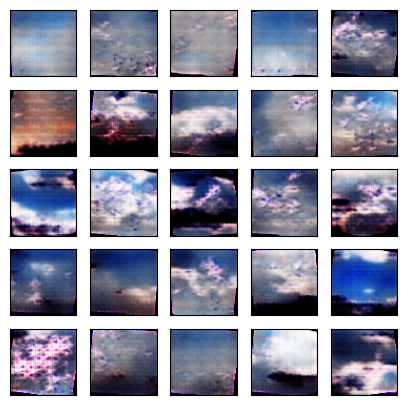

Epoch [90/300], D Loss: -0.7615, G Loss: 13.2080


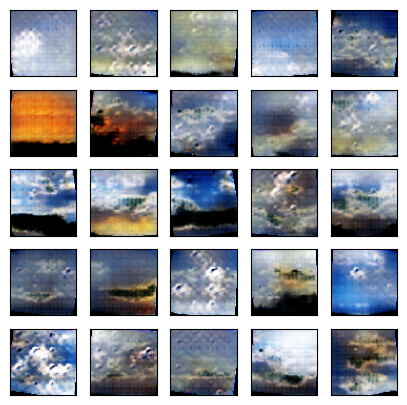

Epoch [120/300], D Loss: -1.8495, G Loss: 13.5389


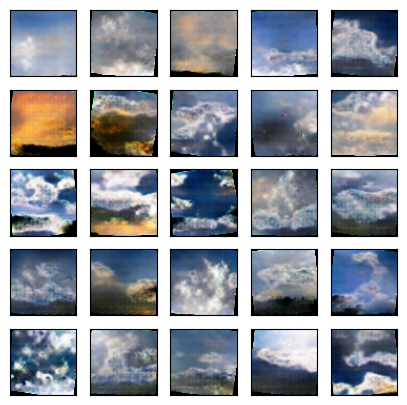

Epoch [150/300], D Loss: -1.4135, G Loss: 12.9703


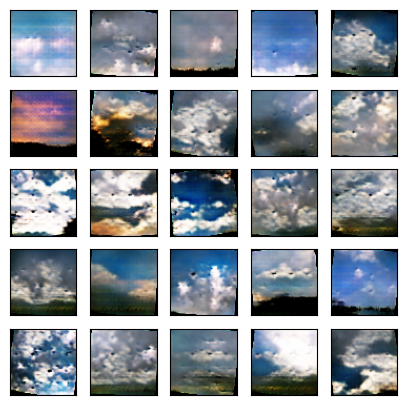

Epoch [180/300], D Loss: -2.0285, G Loss: 16.6629


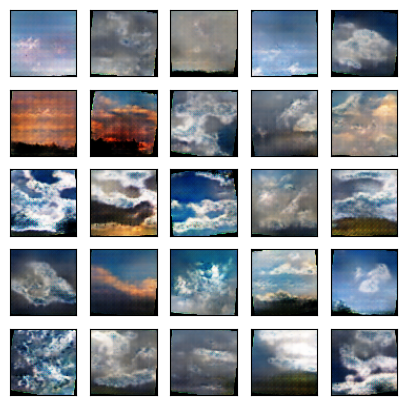

Epoch [210/300], D Loss: -2.8151, G Loss: 17.0644


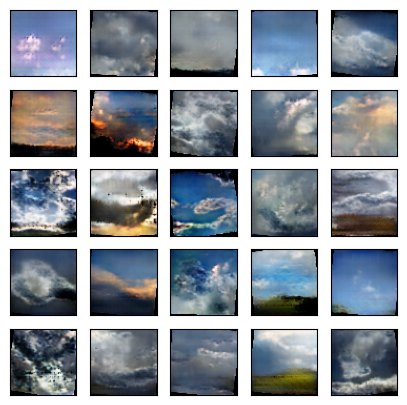

Epoch [240/300], D Loss: -2.6118, G Loss: 19.7741


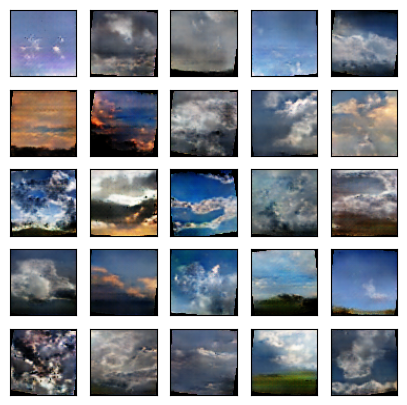

Epoch [270/300], D Loss: -3.0345, G Loss: 14.4638


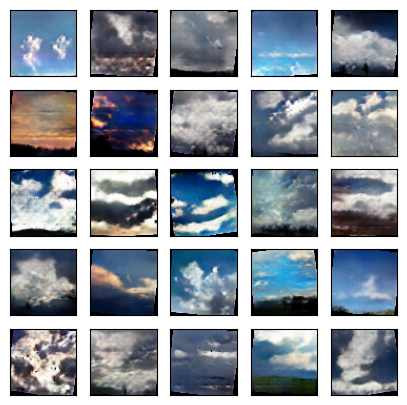

Epoch [300/300], D Loss: -3.9044, G Loss: 17.4849


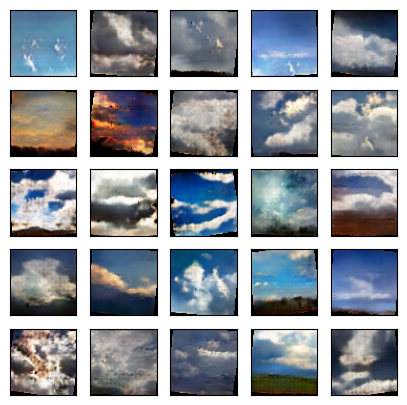

Total training time: 434.30s


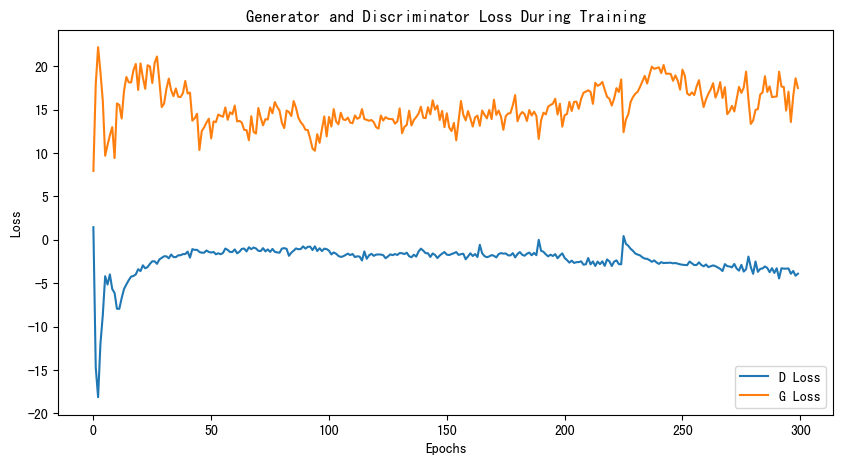

In [1]:
import os
import time
import itertools
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import matplotlib.pyplot as plt

class SpectralNorm(nn.Module):
    def __init__(self, module, name='weight', power_iterations=1):
        super(SpectralNorm, self).__init__()
        self.module = module
        self.name = name
        self.power_iterations = power_iterations
        if not self._made_params():
            self._make_params()

    def _update_u_v(self):
        w = getattr(self.module, self.name + '_orig')
        u = getattr(self.module, self.name + '_u')

        height = w.data.shape[0]
        for _ in range(self.power_iterations):
            v = F.normalize(torch.matmul(u, w.view(height, -1).data), dim=0, eps=1e-12)
            u = F.normalize(torch.matmul(v, w.view(height, -1).data.t()), dim=0, eps=1e-12)

        sigma = u.dot(w.view(height, -1).mv(v))
        setattr(self.module, self.name, w / sigma.expand_as(w))

    def _made_params(self):
        try:
            u = getattr(self.module, self.name + '_u')
            v = getattr(self.module, self.name + '_v')
            w = getattr(self.module, self.name + '_bar')
            return True
        except AttributeError:
            return False

    def _make_params(self):
        w = getattr(self.module, self.name)

        height = w.data.shape[0]
        width = w.view(height, -1).data.shape[1]

        u = nn.Parameter(w.data.new(height).normal_(0, 1), requires_grad=False)
        v = nn.Parameter(w.data.new(width).normal_(0, 1), requires_grad=False)
        u.data = F.normalize(u.data, dim=0, eps=1e-12)
        v.data = F.normalize(v.data, dim=0, eps=1e-12)

        del self.module._parameters[self.name]
        self.module.register_parameter(self.name + '_orig', nn.Parameter(w.data))
        self.module.register_buffer(self.name, w.data)
        self.module.register_buffer(self.name + '_u', u)
        self.module.register_buffer(self.name + '_v', v)

    def forward(self, *args):
        self._update_u_v()
        return self.module.forward(*args)


class CloudDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = [os.path.join(root_dir, f) for f in os.listdir(root_dir) if
                            f.endswith('.png') or f.endswith('.jpg')]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image

class generator(nn.Module):
    def __init__(self, d=128):
        super(generator, self).__init__()
        self.deconv1 = nn.ConvTranspose2d(100, d * 8, 4, 1, 0)
        self.deconv1_bn = nn.BatchNorm2d(d * 8)
        self.deconv2 = nn.ConvTranspose2d(d * 8, d * 4, 4, 2, 1)
        self.deconv2_bn = nn.BatchNorm2d(d * 4)
        self.deconv3 = nn.ConvTranspose2d(d * 4, d * 2, 4, 2, 1)
        self.deconv3_bn = nn.BatchNorm2d(d * 2)
        self.deconv4 = nn.ConvTranspose2d(d * 2, d, 4, 2, 1)
        self.deconv4_bn = nn.BatchNorm2d(d)
        self.deconv5 = nn.ConvTranspose2d(d, 3, 4, 2, 1)

    def weight_init(self, mean, std):
        for m in self.modules():
            if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
                nn.init.xavier_normal_(m.weight.data)
                m.bias.data.zero_()

    def forward(self, input):
        x = F.relu(self.deconv1_bn(self.deconv1(input)))
        x = F.relu(self.deconv2_bn(self.deconv2(x)))
        x = F.relu(self.deconv3_bn(self.deconv3(x)))
        x = F.relu(self.deconv4_bn(self.deconv4(x)))
        x = F.tanh(self.deconv5(x))
        return x


class discriminator(nn.Module):
    def __init__(self, d=128):
        super(discriminator, self).__init__()
        self.conv1 = SpectralNorm(nn.Conv2d(3, d, 4, 2, 1))
        self.conv2 = SpectralNorm(nn.Conv2d(d, d * 2, 4, 2, 1))
        self.conv2_bn = nn.BatchNorm2d(d * 2)
        self.conv3 = SpectralNorm(nn.Conv2d(d * 2, d * 4, 4, 2, 1))
        self.conv3_bn = nn.BatchNorm2d(d * 4)
        self.conv4 = SpectralNorm(nn.Conv2d(d * 4, d * 8, 4, 2, 1))
        self.conv4_bn = nn.BatchNorm2d(d * 8)
        self.conv5 = SpectralNorm(nn.Conv2d(d * 8, 1, 4, 1, 0))

    def weight_init(self, mean, std):
        for m in self.modules():
            if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
                nn.init.xavier_normal_(m.weight.data)
                m.bias.data.zero_()

    def forward(self, input):
        x = F.leaky_relu(self.conv1(input), 0.2)
        x = F.leaky_relu(self.conv2_bn(self.conv2(x)), 0.2)
        x = F.leaky_relu(self.conv3_bn(self.conv3(x)), 0.2)
        x = F.leaky_relu(self.conv4_bn(self.conv4(x)), 0.2)
        x = self.conv5(x)
        return x


# loss WGAN-GP
def gradient_penalty(D, real_samples, fake_samples, device="cuda"):
    alpha = torch.rand(real_samples.size(0), 1, 1, 1).to(device)
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    d_interpolates = D(interpolates)
    gradients = torch.autograd.grad(outputs=d_interpolates, inputs=interpolates,
                                    grad_outputs=torch.ones(d_interpolates.size()).to(device),
                                    create_graph=True, retain_graph=True, only_inputs=True)[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

def D_loss_wgan_gp(D, real_samples, fake_samples, lambda_gp=10, device="cuda"):
    D_real = D(real_samples)
    D_fake = D(fake_samples)
    gp = gradient_penalty(D, real_samples, fake_samples, device)
    return -torch.mean(D_real) + torch.mean(D_fake) + lambda_gp * gp

def G_loss_wgan(D_fake):
    return -torch.mean(D_fake)


batch_size = 32
lr = 0.001
train_epoch = 300
img_size = 64
transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.RandomHorizontalFlip(), 
    transforms.RandomRotation(10),      
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])
root_dir = 'Cloud'
cloud_dataset = CloudDataset(root_dir, transform=transform)
train_loader = DataLoader(cloud_dataset, batch_size=batch_size, shuffle=True, num_workers=4)


G = generator(128).cuda()
D = discriminator(128).cuda()
G.weight_init(mean=0.0, std=0.02)
D.weight_init(mean=0.0, std=0.02)

G_optimizer = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
D_optimizer = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))
fixed_z_ = torch.randn((5 * 5, 100)).view(-1, 100, 1, 1).cuda()
D_losses = []
G_losses = []

scheduler_G = optim.lr_scheduler.StepLR(G_optimizer, step_size=100, gamma=0.5)
scheduler_D = optim.lr_scheduler.StepLR(D_optimizer, step_size=100, gamma=0.5)


print('training start!')
start_time = time.time()
for epoch in range(train_epoch):
    D_epoch_losses = []
    G_epoch_losses = []
    for x_ in train_loader:
        D.zero_grad()
        mini_batch = x_.size()[0]
        x_ = x_.cuda()
        D_result = D(x_).squeeze()

        z_ = torch.randn((mini_batch, 100)).view(-1, 100, 1, 1).cuda()
        G_result = G(z_)
        D_result_fake = D(G_result).squeeze()

        D_train_loss = D_loss_wgan_gp(D, x_, G_result, device="cuda")
        D_train_loss.backward()
        D_optimizer.step()
        D_epoch_losses.append(D_train_loss.item())

        G.zero_grad()
        z_ = torch.randn((mini_batch, 100)).view(-1, 100, 1, 1).cuda()
        G_result = G(z_)
        D_result = D(G_result).mean()

        G_train_loss = G_loss_wgan(D_result)
        G_train_loss.backward()
        G_optimizer.step()
        G_epoch_losses.append(G_train_loss.item())

    scheduler_G.step()
    scheduler_D.step()

    if (epoch + 1) % 30 == 0:
        print(f'Epoch [{epoch + 1}/{train_epoch}], D Loss: {torch.mean(torch.FloatTensor(D_epoch_losses)):.4f}, G Loss: {torch.mean(torch.FloatTensor(G_epoch_losses)):.4f}')
        with torch.no_grad():
            G.eval()
            test_images = G(fixed_z_)
            G.train()

            test_images = (test_images + 1) / 2
            test_images = torch.clamp(test_images, 0, 1)
            size_figure_grid = 5
            fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(5, 5))
            for i, j in itertools.product(range(size_figure_grid), range(size_figure_grid)):
                ax[i, j].get_xaxis().set_visible(False)
                ax[i, j].get_yaxis().set_visible(False)
            for k in range(5 * 5):
                i = k // 5
                j = k % 5
                ax[i, j].cla()
                ax[i, j].imshow(test_images[k].permute(1, 2, 0).cpu().numpy())
            plt.show()

    D_losses.append(torch.mean(torch.FloatTensor(D_epoch_losses)).item())
    G_losses.append(torch.mean(torch.FloatTensor(G_epoch_losses)).item())

end_time = time.time()
print(f"Total training time: {end_time - start_time:.2f}s")

plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(D_losses, label="D Loss")
plt.plot(G_losses, label="G Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

The generated cloud images look quite nice, especially for a resolution of 64x64.